In [345]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.stats as stats


In [346]:
kfolds = 10
lambs = ['0', '1', '10', '100', '1000', '10000', '100000']
cutoff = 10**-11

In [379]:
def pull_data(recomb_file):
    genome_in_hotspot_mat, genome_in_hotspot_pat, genome_in_hotspot = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    co_in_hotspot_mat_train, co_in_hotspot_pat_train = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    co_in_hotspot_mat_test, co_in_hotspot_pat_test = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
    
    lengths = np.load('%s.lengths.npy' % recomb_file)

    for i, lamb in enumerate(lambs):
        for k in range(kfolds):
            try:
                ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
                is_mat_hotspot = (ps_mat/lengths > cutoff)

                co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_mat_train = np.load('%s.crossover_lengths_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_mat_test = np.load('%s.crossover_lengths_mat_test.%s.%d.npy' % (recomb_file, lamb, k))

                co_ps_mat_train = np.clip(co_ps_mat_train, co_lengths_mat_train*10**-12, None)
                co_ps_mat_test = np.clip(co_ps_mat_test, co_lengths_mat_test*10**-12, None)
                genome_in_hotspot_mat[i, k] = is_mat_hotspot.dot(lengths)/np.sum(lengths)
                co_in_hotspot_mat_train[i, k] = np.sum(np.log(co_ps_mat_train))/len(co_ps_mat_train)
                co_in_hotspot_mat_test[i, k] = np.sum(np.log(co_ps_mat_test))/len(co_ps_mat_test)

                ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
                is_pat_hotspot = (ps_pat/lengths > cutoff)

                co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_pat_train = np.load('%s.crossover_lengths_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
                co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%s.%d.npy' % (recomb_file, lamb, k))
                co_lengths_pat_test = np.load('%s.crossover_lengths_pat_test.%s.%d.npy' % (recomb_file, lamb, k))

                co_ps_pat_train = np.clip(co_ps_pat_train, co_lengths_pat_train*10**-12, None)
                co_ps_pat_test = np.clip(co_ps_pat_test, co_lengths_pat_test*10**-12, None)
                genome_in_hotspot_pat[i, k] = is_pat_hotspot.dot(lengths)/np.sum(lengths)
                co_in_hotspot_pat_train[i, k] = np.sum(np.log(co_ps_pat_train))/len(co_ps_pat_train)
                co_in_hotspot_pat_test[i, k] = np.sum(np.log(co_ps_pat_test))/len(co_ps_pat_test)
                genome_in_hotspot[i, k] = (is_mat_hotspot & is_pat_hotspot).dot(lengths)/np.sum(lengths)
            except Exception as e:
                print(e)
    return genome_in_hotspot_mat, genome_in_hotspot_pat, genome_in_hotspot, co_in_hotspot_mat_train, co_in_hotspot_pat_train, co_in_hotspot_mat_test, co_in_hotspot_pat_test

wgs_genome_in_hotspot_mat, wgs_genome_in_hotspot_pat, wgs_genome_in_hotspot, \
wgs_co_in_hotspot_mat_train, wgs_co_in_hotspot_pat_train, \
wgs_co_in_hotspot_mat_test, wgs_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs')

chip_genome_in_hotspot_mat, chip_genome_in_hotspot_pat, chip_genome_in_hotspot, \
chip_co_in_hotspot_mat_train, chip_co_in_hotspot_pat_train, \
chip_co_in_hotspot_mat_test, chip_co_in_hotspot_pat_test = pull_data('../recombination_rate/chip')

wgs_chip_genome_in_hotspot_mat, wgs_chip_genome_in_hotspot_pat, wgs_chip_genome_in_hotspot, \
wgs_chip_co_in_hotspot_mat_train, wgs_chip_co_in_hotspot_pat_train, \
wgs_chip_co_in_hotspot_mat_test, wgs_chip_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_chip')

wgs_linked_genome_in_hotspot_mat, wgs_linked_genome_in_hotspot_pat, wgs_linked_genome_in_hotspot, \
wgs_linked_co_in_hotspot_mat_train, wgs_linked_co_in_hotspot_pat_train, \
wgs_linked_co_in_hotspot_mat_test, wgs_linked_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_linked')

chip_linked_genome_in_hotspot_mat, chip_linked_genome_in_hotspot_pat, chip_linked_genome_in_hotspot, \
chip_linked_co_in_hotspot_mat_train, chip_linked_co_in_hotspot_pat_train, \
chip_linked_co_in_hotspot_mat_test, chip_linked_co_in_hotspot_pat_test = pull_data('../recombination_rate/chip_linked')

wgs_chip_linked_genome_in_hotspot_mat, wgs_chip_linked_genome_in_hotspot_pat, wgs_chip_linked_genome_in_hotspot, \
wgs_chip_linked_co_in_hotspot_mat_train, wgs_chip_linked_co_in_hotspot_pat_train, \
wgs_chip_linked_co_in_hotspot_mat_test, wgs_chip_linked_co_in_hotspot_pat_test = pull_data('../recombination_rate/wgs_chip_linked')


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater


[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.0.2.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.0.3.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.0.4.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.0.5.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.0.6.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.0.7.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.0.8.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_chip.ps_mat.0.9.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked.ps_mat.0.0.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked.ps_mat.0.1.npy'
[Errno 2] No such file or directory: '../recombination_rate/wgs_linked.ps_mat.0.2.npy'
[Errno 2] No such file or directory: '../recombination_rate

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


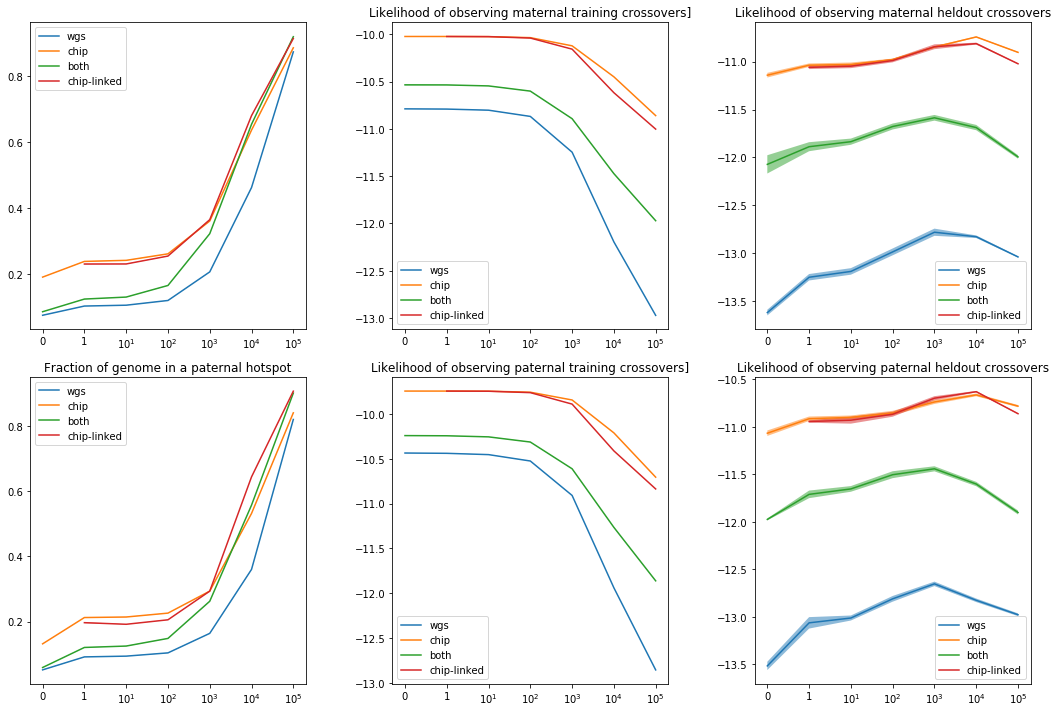

In [381]:
def plot_with_confidence(data, label):
    #print(np.nanmean(data, axis=1))
    plt.plot(np.nanmean(data, axis=1), label=label)
    lower, upper = stats.t.interval(0.95, data.shape[1]-1, loc=np.nanmean(data, axis=1), scale=stats.sem(data, axis=1, nan_policy='omit')) # from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    plt.fill_between(np.arange(len(lambs)), lower, upper, alpha=0.5)


plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plot_with_confidence(wgs_genome_in_hotspot_mat, 'wgs')
plot_with_confidence(chip_genome_in_hotspot_mat, 'chip')
plot_with_confidence(wgs_chip_genome_in_hotspot_mat, 'both')
#plot_with_confidence(wgs_linked_genome_in_hotspot_mat, 'wgs-linked')
plot_with_confidence(chip_linked_genome_in_hotspot_mat, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_genome_in_hotspot_mat, 'both-linked')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 4)
plot_with_confidence(wgs_genome_in_hotspot_pat, 'wgs')
plot_with_confidence(chip_genome_in_hotspot_pat, 'chip')
plot_with_confidence(wgs_chip_genome_in_hotspot_pat, 'both')
#plot_with_confidence(wgs_linked_genome_in_hotspot_pat, 'wgs-linked')
plot_with_confidence(chip_linked_genome_in_hotspot_pat, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_genome_in_hotspot_pat, 'both-linked')
plt.title('Fraction of genome in a paternal hotspot')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 2)
plot_with_confidence(wgs_co_in_hotspot_mat_train, 'wgs')
plot_with_confidence(chip_co_in_hotspot_mat_train, 'chip')
plot_with_confidence(wgs_chip_co_in_hotspot_mat_train, 'both')
#plot_with_confidence(wgs_linked_co_in_hotspot_mat_train, 'wgs-linked')
plot_with_confidence(chip_linked_co_in_hotspot_mat_train, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_mat_train, 'both-linked')
plt.title('Likelihood of observing maternal training crossovers]')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 5)
plot_with_confidence(wgs_co_in_hotspot_pat_train, 'wgs')
plot_with_confidence(chip_co_in_hotspot_pat_train, 'chip')
plot_with_confidence(wgs_chip_co_in_hotspot_pat_train, 'both')
#plot_with_confidence(wgs_linked_co_in_hotspot_pat_train, 'wgs-linked')
plot_with_confidence(chip_linked_co_in_hotspot_pat_train, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_pat_train, 'both-linked')
plt.title('Likelihood of observing paternal training crossovers]')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 3)
plot_with_confidence(wgs_co_in_hotspot_mat_test, 'wgs')
plot_with_confidence(chip_co_in_hotspot_mat_test, 'chip')
plot_with_confidence(wgs_chip_co_in_hotspot_mat_test, 'both')
#plot_with_confidence(wgs_linked_co_in_hotspot_mat_test, 'wgs-linked')
plot_with_confidence(chip_linked_co_in_hotspot_mat_test, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_mat_test, 'both-linked')
plt.title('Likelihood of observing maternal heldout crossovers')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.subplot(2, 3, 6)
plot_with_confidence(wgs_co_in_hotspot_pat_test, 'wgs')
plot_with_confidence(chip_co_in_hotspot_pat_test, 'chip')
plot_with_confidence(wgs_chip_co_in_hotspot_pat_test, 'both')
#plot_with_confidence(wgs_linked_co_in_hotspot_pat_test, 'wgs-linked')
plot_with_confidence(chip_linked_co_in_hotspot_pat_test, 'chip-linked')
#plot_with_confidence(wgs_chip_linked_co_in_hotspot_pat_test, 'both-linked')
plt.title('Likelihood of observing paternal heldout crossovers')
plt.xticks(range(len(lambs)), map(lambda x: str(x) if x in {'0', '1'} else '$10^{%d}$' % np.log10(float(x)), lambs))
plt.legend()

plt.tight_layout()
plt.show()

In [365]:
lamb_wgs_mat = lambs[np.argmax(np.nanmean(wgs_co_in_hotspot_mat_test, axis=1))]
lamb_wgs_pat = lambs[np.argmax(np.nanmean(wgs_co_in_hotspot_pat_test, axis=1))]
lamb_chip_mat = lambs[np.argmax(np.nanmean(chip_co_in_hotspot_mat_test, axis=1))]
lamb_chip_pat = lambs[np.argmax(np.nanmean(chip_co_in_hotspot_pat_test, axis=1))]
lamb_wgschip_mat = lambs[np.argmax(np.nanmean(wgs_chip_co_in_hotspot_mat_test, axis=1))]
lamb_wgschip_pat = lambs[np.argmax(np.nanmean(wgs_chip_co_in_hotspot_pat_test, axis=1))]

print(lamb_wgs_mat, lamb_wgs_pat)
print(lamb_chip_mat, lamb_chip_pat)
print(lamb_wgschip_mat, lamb_wgschip_pat)

1000 1000
10000 10000
1000 1000


# Look at best performers

591701 (591700,) (591700,) (591700,)
[('1', 1), ('1', 54708), ('1', 65745), ('1', 79772), ('1', 88169)]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log10


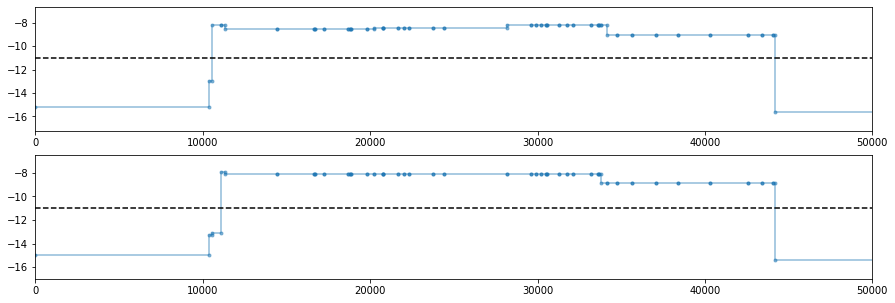

In [438]:
chrom = '16'
lamb = '1000'
k = 0
recomb_file = '../recombination_rate/wgs'

all_positions = []
with open('%s.positions.txt' % recomb_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        all_positions.append((pieces[0], int(pieces[1])))
lengths = np.load('%s.lengths.npy' % recomb_file)
        
ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
print(len(all_positions), lengths.shape, ps_mat.shape, ps_pat.shape)
print(all_positions[:5])

plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
indices = [c==chrom for c, p in all_positions[:-1]]
p = plt.plot(np.repeat([p for c, p in all_positions[:-1] if c==chrom], 2)[1:], 
         np.repeat((np.log10(ps_mat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)
plt.axhline(-11, color='black', linestyle='--')
plt.xlim([0, 50000])

plt.subplot(2, 1, 2)
indices = [c==chrom for c, p in all_positions[:-1]]
q = plt.plot(np.repeat([p for c, p in all_positions[:-1] if c==chrom], 2)[1:], 
         np.repeat((np.log10(ps_pat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)
plt.axhline(-11, color='black', linestyle='--')

#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)

plt.xlim([0, 50000])
plt.show()


In [417]:
chrom = '20'
lamb = '1000'
k = 0
recomb_file = '../recombination_rate/wgs_chip'

all_positions = []
with open('%s.positions.txt' % recomb_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        all_positions.append((pieces[0], int(pieces[1])))
lengths = np.load('%s.lengths.npy' % recomb_file)
        
ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
print(len(all_positions), lengths.shape, ps_mat.shape, ps_pat.shape)
print(all_positions[:5])

plt.figure(figsize=(15, 5))
s = pd.Series(np.log10(ps_mat[indices])-np.log10(lengths[indices]))
indices = [c==chrom for c, p in all_positions[:-1]]
plt.fill_between([p for c, p in all_positions[:-1] if c==chrom], 
          s.rolling(1000).quantile(0.95),
          s.rolling(1000).quantile(0.05))
#indices = [c==chrom for c, p in all_positions[:-1]]
#q = plt.plot(np.repeat([p for c, p in all_positions[:-1] if c==chrom], 2)[1:], 
#         np.repeat((np.log10(ps_pat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)
plt.axhline(-11, color='black', linestyle='--')

#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)

#plt.xlim([22000000, 23000000])
plt.show()


ImportError: cannot import name '_np_version_under1p18' from 'pandas.compat.numpy' (//anaconda3/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


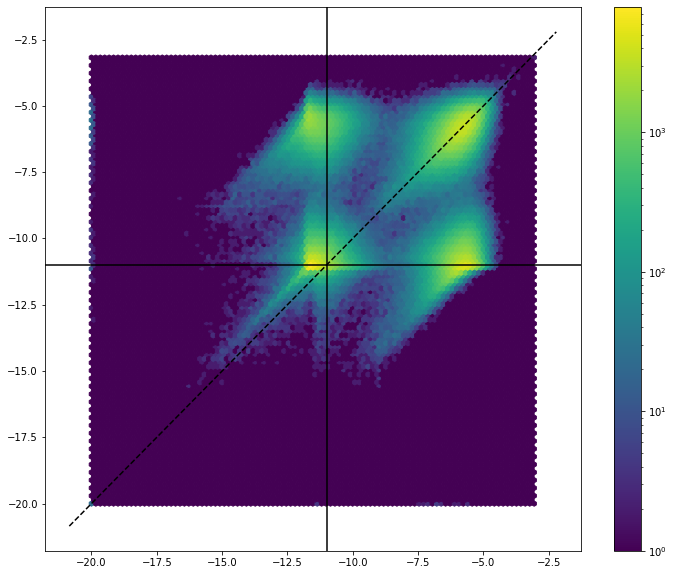

In [400]:
recomb_file = '../recombination_rate/wgs_chip'
lengths = np.load('%s.lengths.npy' % recomb_file)
ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))

plt.figure(figsize=(12, 10))
plt.hexbin(np.clip(np.log10(ps_mat[lengths!=0]), -20, 0), 
            np.clip(np.log10(ps_pat[lengths!=0]), -20, 0),
          gridsize=100, bins='log')#, marker='.', alpha=0.1)
plt.colorbar()
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.axhline(np.log10(cutoff), color='black')
plt.axvline(np.log10(cutoff), color='black')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site

Maternal
genome in hotspot 0.32316439000118785
train crossovers in hotspot 0.9999027617683582
test crossovers in hotspot 0.9242347400833182


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in greater


Paternal
genome in hotspot 0.2639510254168563
train crossovers in hotspot 0.9998968972315344
test crossovers in hotspot 0.9108229539896491


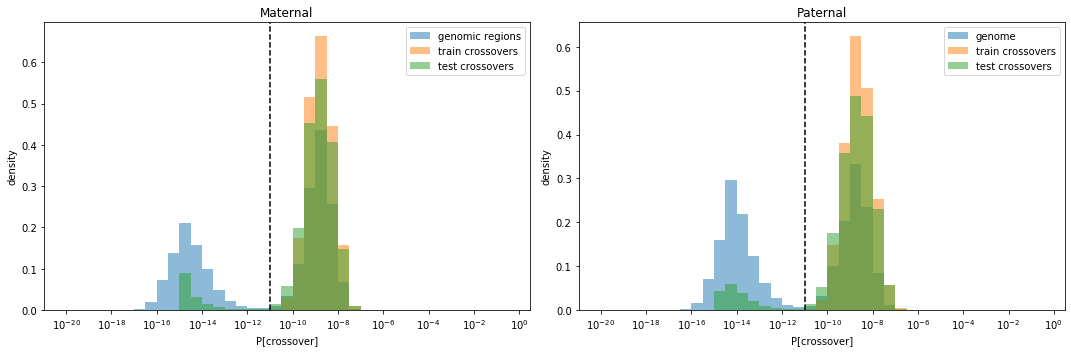

In [359]:
recomb_file = '../recombination_rate/wgs_chip'
k = 0
lamb = '1000'

lengths = np.load('%s.lengths.npy' % recomb_file)

plt.figure(figsize=(15, 5))
bins = np.arange(-20, 0, 0.5)


plt.subplot(1, 2, 1)
#co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%.0f.%d.npy' % (recomb_file, lamb, k))
#co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%.0f.%d.npy' % (recomb_file, lamb, k))

#X_mat_train = sparse.load_npz('%s.X_mat_train.%s.%d.npz' % (recomb_file, lamb, k))
#X_mat_test = sparse.load_npz('%s.X_mat_test.%s.%d.npz' % (recomb_file, lamb, k))

ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
plt.hist(np.log10(ps_mat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label='genomic regions')
is_hotspot_mat = (ps_mat/lengths > cutoff)
    
co_ps_mat_train = np.load('%s.crossover_ps_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
co_lengths_mat_train = np.load('%s.crossover_lengths_mat_train.%s.%d.npy' % (recomb_file, lamb, k))
co_ps_mat_test = np.load('%s.crossover_ps_mat_test.%s.%d.npy' % (recomb_file, lamb, k))
co_lengths_mat_test = np.load('%s.crossover_lengths_mat_test.%s.%d.npy' % (recomb_file, lamb, k))

print('Maternal')
print('genome in hotspot', (ps_mat/lengths > cutoff).dot(lengths)/np.sum(lengths))
print('train crossovers in hotspot', np.sum(co_ps_mat_train/co_lengths_mat_train > cutoff)/len(co_ps_mat_train))
print('test crossovers in hotspot', np.sum(co_ps_mat_test/co_lengths_mat_test > cutoff)/len(co_ps_mat_test))
    
plt.hist(np.clip(np.log10(co_ps_mat_train) - np.log10(co_lengths_mat_train), -15, 0), alpha=0.5, bins=bins, density=True, label='train crossovers')
plt.hist(np.clip(np.log10(co_ps_mat_test) - np.log10(co_lengths_mat_test), -15, 0), alpha=0.5, bins=bins, density=True, label='test crossovers')

plt.title('Maternal')
plt.xlabel('P[crossover]')
plt.ylabel('density')
plt.xticks(np.arange(-20, 2, 2), ['$10^{%d}$' % x for x in np.arange(-20, 2, 2)])
plt.legend()
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.subplot(1, 2, 2)
#co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%.0f.%d.npy' % (recomb_file, lamb, k))
#co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%.0f.%d.npy' % (recomb_file, lamb, k))
    
#X_pat_train = sparse.load_npz('%s.X_pat_train.%s.%d.npz' % (recomb_file, lamb, k))
#X_pat_test = sparse.load_npz('%s.X_pat_test.%s.%d.npz' % (recomb_file, lamb, k))
    
ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
plt.hist(np.log10(ps_pat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label='genome')

co_ps_pat_train = np.load('%s.crossover_ps_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
co_lengths_pat_train = np.load('%s.crossover_lengths_pat_train.%s.%d.npy' % (recomb_file, lamb, k))
co_ps_pat_test = np.load('%s.crossover_ps_pat_test.%s.%d.npy' % (recomb_file, lamb, k))
co_lengths_pat_test = np.load('%s.crossover_lengths_pat_test.%s.%d.npy' % (recomb_file, lamb, k))
 
print('Paternal')
print('genome in hotspot', (ps_pat/lengths > cutoff).dot(lengths)/np.sum(lengths))
print('train crossovers in hotspot', np.sum(co_ps_pat_train/co_lengths_pat_train > cutoff)/len(co_ps_pat_train))
print('test crossovers in hotspot', np.sum(co_ps_pat_test/co_lengths_pat_test > cutoff)/len(co_ps_pat_test))

plt.hist(np.clip(np.log10(co_ps_pat_train) - np.log10(co_lengths_pat_train), -15, 0), alpha=0.5, bins=bins, density=True, label='train crossovers')
plt.hist(np.clip(np.log10(co_ps_pat_test) - np.log10(co_lengths_pat_test), -15, 0), alpha=0.5, bins=bins, density=True, label='test crossovers')

plt.title('Paternal')
plt.xlabel('P[crossover]')
plt.xticks(np.arange(-20, 2, 2), ['$10^{%d}$' % x for x in np.arange(-20, 2, 2)])
plt.ylabel('density')
plt.legend()  
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in greater


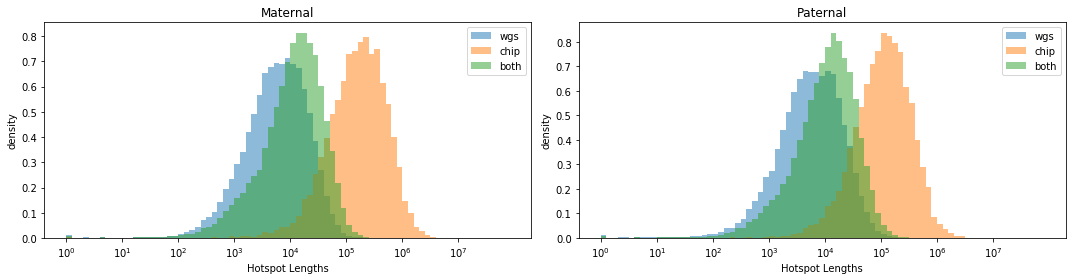

In [378]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
for recomb_file, lamb, label in zip(['../recombination_rate/wgs', '../recombination_rate/chip', '../recombination_rate/wgs_chip'],
                                    ['1000', '10000', '1000'],
                                    ['wgs', 'chip', 'both']):
    lengths = np.load('%s.lengths.npy' % recomb_file)
    ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
    is_hotspot_mat = (ps_mat/lengths > cutoff)
    hotspot_length = []
    hotspot_starts, hotspot_ends = np.where(~is_hotspot_mat[:-1] & is_hotspot_mat[1:])[0]+1, np.where(is_hotspot_mat[:-1] & ~is_hotspot_mat[1:])[0]+1
    if is_hotspot_mat[0]:
        hotspot_starts = np.hstack((0, hotspot_starts))
    if is_hotspot_mat[-1]:
        hotspot_ends = np.hstack((hotspot_ends, len(is_hotspot_mat)))
    for hotspot_start_index, hotspot_end_index in zip(hotspot_starts, hotspot_ends):
        hotspot_length.append(np.sum(lengths[hotspot_start_index:hotspot_end_index]))
    plt.hist(np.clip(np.log10(hotspot_length), 0, 8), alpha=0.5, bins=np.arange(0, 8, 0.1), density=True, label=label)

plt.title('Maternal')
plt.xlabel('Hotspot Lengths')
plt.ylabel('density')
plt.xticks(np.arange(0, 8), ['$10^{%d}$' % x for x in np.arange(0, 8)])
plt.legend()

plt.subplot(1, 2, 2)
for recomb_file, lamb, label in zip(['../recombination_rate/wgs', '../recombination_rate/chip', '../recombination_rate/wgs_chip'],
                                    ['1000', '10000', '1000'],
                                    ['wgs', 'chip', 'both']):
    lengths = np.load('%s.lengths.npy' % recomb_file)
    ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
    is_hotspot_pat = (ps_pat/lengths > cutoff)
    hotspot_length = []
    hotspot_starts, hotspot_ends = np.where(~is_hotspot_pat[:-1] & is_hotspot_pat[1:])[0]+1, np.where(is_hotspot_pat[:-1] & ~is_hotspot_pat[1:])[0]+1
    if is_hotspot_pat[0]:
        hotspot_starts = np.hstack((0, hotspot_starts))
    if is_hotspot_pat[-1]:
        hotspot_ends = np.hstack((hotspot_ends, len(is_hotspot_pat)))
    for hotspot_start_index, hotspot_end_index in zip(hotspot_starts, hotspot_ends):
        hotspot_length.append(np.sum(lengths[hotspot_start_index:hotspot_end_index]))
    plt.hist(np.clip(np.log10(hotspot_length), 0, 8), alpha=0.5, bins=np.arange(0, 8, 0.1), density=True, label=label)

plt.title('Paternal')
plt.xlabel('Hotspot Lengths')
plt.xticks(np.arange(0, 8), ['$10^{%d}$' % x for x in np.arange(0, 8)])
plt.ylabel('density')
plt.legend()  

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in subtract
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in subtract


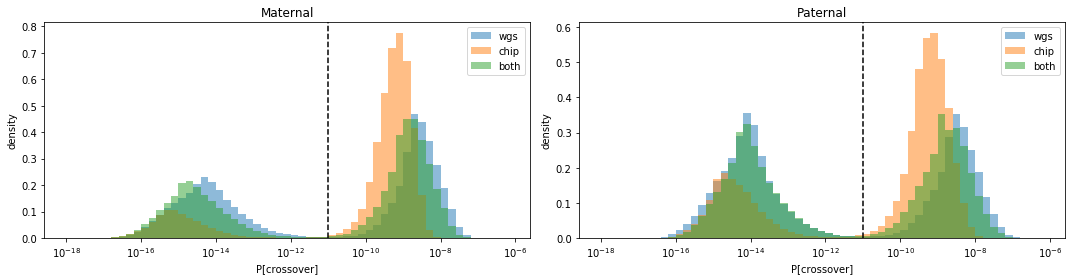

In [377]:
plt.figure(figsize=(15, 4))
bins = np.arange(-18, -6, 0.2)
plt.subplot(1, 2, 1)
for recomb_file, lamb, label in zip(['../recombination_rate/wgs', '../recombination_rate/chip', '../recombination_rate/wgs_chip'],
                                    ['1000', '10000', '1000'],
                                    ['wgs', 'chip', 'both']):
    lengths = np.load('%s.lengths.npy' % recomb_file)
    ps_mat = np.load('%s.ps_mat.%s.%d.npy' % (recomb_file, lamb, k))
    plt.hist(np.log10(ps_mat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label=label)

plt.title('Maternal')
plt.xlabel('P[crossover]')
plt.ylabel('density')
plt.xticks(np.arange(-18, -4, 2), ['$10^{%d}$' % x for x in np.arange(-18, -4, 2)])
plt.legend()
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.subplot(1, 2, 2)
for recomb_file, lamb, label in zip(['../recombination_rate/wgs', '../recombination_rate/chip', '../recombination_rate/wgs_chip'],
                                    ['1000', '10000', '1000'],
                                    ['wgs', 'chip', 'both']):
    lengths = np.load('%s.lengths.npy' % recomb_file)
    ps_pat = np.load('%s.ps_pat.%s.%d.npy' % (recomb_file, lamb, k))
    plt.hist(np.log10(ps_pat)-np.log10(lengths), alpha=0.5, bins=bins, density=True, label=label)

plt.title('Paternal')
plt.xlabel('P[crossover]')
plt.xticks(np.arange(-18, -4, 2), ['$10^{%d}$' % x for x in np.arange(-18, -4, 2)])
plt.ylabel('density')
plt.legend()  
plt.axvline(np.log10(cutoff), color='black', linestyle='--')

plt.tight_layout()
plt.show()